# 2 _k_-Means Clustering

In this notebook, we will explore and cluster data with the _k_-Means algorithm.

In _k_-Means, a dataset is partitioned in _k_ clusters while trying to minimize the sum of squared distances of each point to its cluster center. One of the characteristics of this algorithm is that the number of clusters _k_ is predefined, i.e., the choice is left to the machine learning practitioner.

You can find an overview of the algorithm in the lecture slides.

As usual, we start with importing the packages:

In [2]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import math
np.random.seed(1337) # seeds help with reproducible results
%matplotlib inline

## 2.1 The Dataset
We are going to use a familiar dataset, the [Iris Dataset](https://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html).
The dataset contains four features: sepal length, sepal width, petal length and petal width. We want to be able to look at our clustering results later. Four-dimensional data are hard to visualize for human brains. Thankfully, we know a handy dimensionality reduction technique, i.e., Principal Component Analysis (PCA).

### Task 2.1.1 Transform the Data
 1. Load the Iris Dataset.
 2. Use the PCA class from sklearn to project the dataset into a two-dimensional space.

In [3]:
iris = load_iris()
print(iris.DESCR)
n_comp = min(len(iris["data"]), len(iris["feature_names"]))
pca = PCA(n_components=n_comp)
transformed_iris = pca.fit_transform(iris["data"])
# print(transformed_iris)
# iris to 2D

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

## 2.2 Initialization
Before we start with the learning phase, we need to set up a few initial parameters.

### Task 2.2.1 The _k_-Question
As mentioned, the choice of the right _k_ is an important decision for the success of the algorithm. The number of clusters you will retrieve in the end depends on _k_. Too many or too few clusters might give you suboptimal results.

Fortunately, we know that the Iris Dataset is labeled. Those labels already partition the data. Therefore, let's choose _k_ according to the number of labels.

In [22]:
k = 3

### Task 2.2.2 The First Cluster Centers
You have to start somewhere! Theoretically, you could choose arbitrary points in the input space. Unfortunately, if we choose those randomly, the algorithm might take a while to converge.

In order to speed things up a little, let's choose different random datapoints from the dataset as the initial cluster centers.

_Hint: `numpy.random` has a few good functions for that purpose._

In [23]:
def get_arbitary_points(dataset, k):
    return dataset["data"][np.random.choice(dataset["data"].shape[0], k, replace=False), :]

arbitary_points = get_arbitary_points(iris, k)
print(arbitary_points)

[[5.7 2.9 4.2 1.3]
 [6.3 2.3 4.4 1.3]
 [6.6 3.  4.4 1.4]]


## 2.3 The Algorithm
Now the algorithm goes as follows:

    - obtain the distance of each point to each cluster center
    - assign that point to the nearest cluster
    - move position of centre to mean of points in cluster
    
Thus, we need a few calculation steps. Note that the use of libraries outside the Python Standard Library and `numpy` is not allowed in the following tasks, unless stated otherwise.

### Task 2.3.1 Compute the Distances
Complete the function `distances(...)` that takes a list/array of datapoints and a list/array of cluster centers and returns the distance of each data point to each cluster center.

In [6]:
def distances(data, centroids):
    distances_to_centroids = []
    for data_point in data:
        individual_distance = []
        
        for i in range(len(centroids)):
            # Calculate the distance | get distance for each datapoint to each centroid
            # Linalg.norm can calculate the euclidean distance between two points: see https://stackoverflow.com/questions/1401712/how-can-the-euclidean-distance-be-calculated-with-numpy
            distance = np.linalg.norm(data_point - centroids[i][:])
            individual_distance.append(distance)
            
        distances_to_centroids.append(individual_distance)
        
    return distances_to_centroids

dist = distances(iris["data"], arbitary_points)
print(dist)

[[3.1256999216175574, 0.37416573867739383, 5.31224999411737], [3.1144823004794877, 0.3, 5.389805191284746], [3.272613634390715, 0.31622776601683783, 5.558776843874919], [3.1224989991991996, 0.5099019513592788, 5.4387498563548595], [3.1670175244226235, 0.4472135954999578, 5.359104402789705], [2.8548204847240397, 0.9695359714832658, 4.917316341257699], [3.209361307176243, 0.5000000000000001, 5.496362433464518], [3.039736830714133, 0.36055512754639885, 5.262128846769148], [3.277193921634788, 0.6999999999999998, 5.6258332716140815], [3.0675723300355937, 0.3464101615137754, 5.332916650389353], [3.0380915061926625, 0.7071067811865477, 5.128352561983234], [3.004995840263344, 0.4898979485566357, 5.264978632435274], [3.178049716414141, 0.36055512754639907, 5.463515351859094], [3.6083237105337433, 0.7416198487095665, 5.945586598477901], [3.3808283008753937, 1.1313708498984758, 5.310367218940701], [3.217141588429083, 1.4352700094407325, 5.089204259999789], [3.2109188716004646, 0.8366600265340756,

### Task 2.3.2 Assign Data Points to Clusters
Now that we can compute the distances to the cluster centres, we need to assign the points to their respective clusters.

Complete the function `compute_assignments(...)` that takes a list/array of data points and a list/array of cluster centers and returns a list of assignments of each data point to the nearest cluster center.

_Hint: Make ample use of the `distances(...)` function you just wrote._

In [7]:
def compute_assignments(data, centroids):
    dists = distances(data, centroids)
    assignments = [[] for i in range(len(centroids))]
    # Get the index of min distance (the cluster) and add the data_point to the corresponding array
    for i in range(len(dists)):
        index_of_min_in_distance = dists[i].index(min(dists[i]))
        assignments[index_of_min_in_distance].append(data[i])
    return assignments    
    
    
ca = compute_assignments(iris["data"], arbitary_points)
print(ca)

[[array([6.4, 3.2, 4.5, 1.5]), array([5.5, 2.3, 4. , 1.3]), array([6.5, 2.8, 4.6, 1.5]), array([5.7, 2.8, 4.5, 1.3]), array([6.3, 3.3, 4.7, 1.6]), array([4.9, 2.4, 3.3, 1. ]), array([6.6, 2.9, 4.6, 1.3]), array([5.2, 2.7, 3.9, 1.4]), array([5. , 2. , 3.5, 1. ]), array([5.9, 3. , 4.2, 1.5]), array([6. , 2.2, 4. , 1. ]), array([6.1, 2.9, 4.7, 1.4]), array([5.6, 2.9, 3.6, 1.3]), array([6.7, 3.1, 4.4, 1.4]), array([5.6, 3. , 4.5, 1.5]), array([5.8, 2.7, 4.1, 1. ]), array([6.2, 2.2, 4.5, 1.5]), array([5.6, 2.5, 3.9, 1.1]), array([5.9, 3.2, 4.8, 1.8]), array([6.1, 2.8, 4. , 1.3]), array([6.3, 2.5, 4.9, 1.5]), array([6.1, 2.8, 4.7, 1.2]), array([6.4, 2.9, 4.3, 1.3]), array([6.6, 3. , 4.4, 1.4]), array([6.8, 2.8, 4.8, 1.4]), array([6. , 2.9, 4.5, 1.5]), array([5.7, 2.6, 3.5, 1. ]), array([5.5, 2.4, 3.8, 1.1]), array([5.5, 2.4, 3.7, 1. ]), array([5.8, 2.7, 3.9, 1.2]), array([6. , 2.7, 5.1, 1.6]), array([5.4, 3. , 4.5, 1.5]), array([6. , 3.4, 4.5, 1.6]), array([6.7, 3.1, 4.7, 1.5]), array([6.3, 

### Task 2.3.3 Update Cluster Centers
Now that we have our clusters, we can compute new centers that better represent the cluster.

Complete the function `update_centers()` that takes takes a list/array of data points and a list/array of assignments and returns the new cluster centers.

In [8]:
def update_centers(data, assignments):
    # -------------- DATA UNUSED --------------
    new_centroids = []
    for cluster in assignments:
        # Now we have each cluster with the corresponding data_points -> Calculate new centroids
        center_summed = np.sum(cluster, axis=0)
        new_centroid = [center_summed[i] / len(cluster) for i in range(len(center_summed))]
        new_centroids.append(new_centroid)
    return new_centroids
            
centers = update_centers(iris["data"], ca)

The most important parts are done! Theoretically, we only need to run the algorithm repeatedly until the cluster centers do not change anymore.

## 2.4 Cluster Quality
As we have seen in previous assignments, blindly running an algorithm without evaluating the quality of its results is not always the best idea.

Hence, we will use the Davies Bouldin (DB) Index to evaluate the quality of our clusters (see also the theory about the DB index in the lecture).

### Task 2.4.1 The Davies-Bouldin Index

Write a function `db_index(...)` that takes a list/array of data points, a list/array of cluster centers, and a list/array of assignments and returns the Davies-Bouldin Index.

You will need to:
    
    - calculate the radii of the clusters, R
    - calculate the inter class distance between the clusters
    - calculate the badness of separation between the clusters, D
    
Lastly, you need to take the average over the relevant D-values of each cluster.

All necessary formulas can be found in Lecture 19 (_Basic Clustering_).

In [9]:
def db_index(data, centroids, assignments):
    # -------------- DATA UNUSED --------------
    # Calculate the radii of the clusters
    radii_of_clusters = [np.linalg.norm(np.array(assignments[i]) - centroids[i]) for i in range(len(centroids))]
    
    inter_class_distance = []
    # Calculate the inter distance of centroids with linalg.norm()
    for i in range(len(centroids)):
        distance_of_centroid_to_centroids = []
        for j in range(len(centroids)):
            distance_of_centroid_to_centroids.append(abs(np.linalg.norm(np.array(centroids[i]) - centroids[j])))
        inter_class_distance.append(distance_of_centroid_to_centroids)
    
    badness_of_seperation = []
    # Calculate the badness of seperation based on the precalculated values
    for i in range(len(radii_of_clusters)):
        badness_of_each_cluster = []
        for j in range(0, len(radii_of_clusters)):
            badness_of_each_cluster.append(0.0 if i == j else (radii_of_clusters[i] + radii_of_clusters[j]) / inter_class_distance[i][j])
        badness_of_seperation.append(badness_of_each_cluster)
    
    worst_seperation = [max(badness_value) for badness_value in badness_of_seperation]
    
    # Output for debugging
    # print("RADII: ")
    # print(radii_of_clusters)
    # print("INTER: ")
    # print(inter_class_distance)
    # print("BADNESS: ")
    # print(badness_of_seperation)
    # print("WORST: ")
    # print(worst_seperation)
    
    return sum(worst_seperation) / len(worst_seperation)
    
    
db_index(iris["data"], centers, ca)

5.189049630715334

## 2.5 Learning Phase

### Task 2.5.1 Iterative Clustering
Finally, we have all the ingredients in order to cluster our data. Remember, we already initialized the first cluster centers.

Therefore, for 20 iterations, you will need to:

    - compute the cluster assignments
    - compute the new cluster centres according to the assignments
    - compute the DB index for the current assignments and cluster centers
    
Do not forget to log relevant data for each iteration:

    - the cluster centers
    - the cluster assignments
    - the DB-Index

In [10]:
def split_data_for_vizualization(assignments):
    """
    Takes a 3D Array with [Clusters[Data_Points[Coordinates]]] and returns a 3D Array
    with [Clusters[Coordinate[data]]]
    
    [[[1, 2, 3, 4], [5, 6, 7, 8]]] -> [[[1, 5], [2, 6], [3, 7], [4, 8]]]
    """
    split_assignments = []
    for cluster in assignments:
        cluster_split = [[], [], [], []]
        for data_point in cluster:
            for i in range(len(data_point)):
                cluster_split[i].append(data_point[i])
        split_assignments.append(cluster_split)
    return split_assignments


def plot_scatter(assigns, cur_centres, detailed_view=False):
    """
    Plots a Scatterplot by matching every Coordinate with each other (detailed_view=True)
    or only two selected coordinates resulting in two plots (detailed_view=False).
    """
    split_assignments = split_data_for_vizualization(assigns)
    
    clear_output(wait=True)
    if detailed_view:
        dimension = len(assignments[0][0])
        plt.figure(figsize=(12, 12))
        k = 1
        for i in range(dimension):
            for j in range(dimension):
                plt.subplot(dimension, dimension, k)
                plt.scatter(split_assignments[0][i], split_assignments[0][j], marker='+', c='red', label='Iris-setosa')
                plt.scatter(split_assignments[1][i], split_assignments[1][j], marker='+', c='blue', label='Iris-versicolour')
                plt.scatter(split_assignments[2][i], split_assignments[2][j], marker='+', c='green', label='Iris-virginica')
                plt.scatter([c[i] for c in cur_centres], [c[j] for c in cur_centres], s=100, c='grey', label='Centroid')
                plt.xlabel("x" + str(i))
                plt.ylabel("x" + str(j))
                k += 1
    else:
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.scatter(split_assignments[0][0], split_assignments[0][2], marker='+', c='red', label='Iris-setosa')
        plt.scatter(split_assignments[1][0], split_assignments[1][2], marker='+', c='blue', label='Iris-versicolour')
        plt.scatter(split_assignments[2][0], split_assignments[2][2], marker='+', c='green', label='Iris-virginica')
        plt.scatter([c[0] for c in cur_centres], [c[2] for c in cur_centres], s=100, c='grey', label='Centroid')
        plt.xlabel("x" + str(0))
        plt.ylabel("x" + str(2))
        
        plt.subplot(1, 2, 2)
        plt.scatter(split_assignments[0][0], split_assignments[0][3], marker='+', c='red', label='Iris-setosa')
        plt.scatter(split_assignments[1][0], split_assignments[1][3], marker='+', c='blue', label='Iris-versicolour')
        plt.scatter(split_assignments[2][0], split_assignments[2][3], marker='+', c='green', label='Iris-virginica')
        plt.scatter([c[0] for c in cur_centres], [c[3] for c in cur_centres], s=100, c='grey', label='Centroid')
        plt.xlabel("x" + str(0))
        plt.ylabel("x" + str(3))

    plt.suptitle("Clustering of the Iris Dataset")
    plt.legend(loc="lower right")
    plt.tight_layout(pad=1.0, w_pad=0.7, h_pad=0.7)
    plt.show()

In [11]:
from IPython.display import clear_output
import time

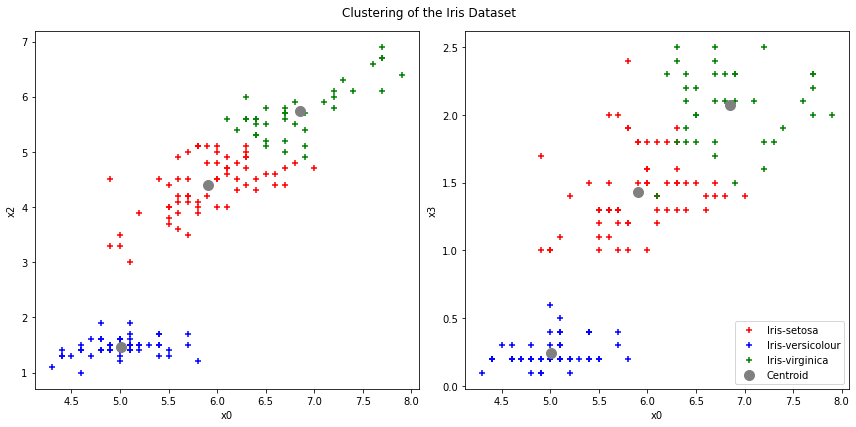

In [62]:
# With the next two lines you can either generate new arbitary points each time this cell is run or set fixed starting points
# arbitary_points = get_arbitary_points(iris, k)
# arbitary_points = [[6.4, 2.8, 5.6, 2.2], [5.8, 2.7, 5.1, 1.9], [6.9, 3.2, 5.7, 2.3]]
iterations = 20
initial_data = iris["data"]
centres = arbitary_points
dbis = []

for i in range(iterations):
    assignments = compute_assignments(initial_data, centres)
    new_centres = update_centers(initial_data, assignments)
    dbi = db_index(initial_data, new_centres, assignments)
    plot_scatter(assignments, centres, detailed_view=False)
    centres = new_centres
    dbis.append(dbi)
    
    # Output for Debugging (or to see detailed data)
    # print("it: " + str(i))
    # [print(assignment, "\n") for assignment in assignments]
    # print("-------------------")
    # print(new_centres)
    # print("-------------------")
    # print(dbi)
    # print("-------------------")
# print("DBIs: ", dbis)

# The detailed assignments and centroids are not logged as textual output because its not easily readable

## 2.6 Evaluation

### Task 2.6.1 Plotting the DB-Index
Plot the DB Index over the iterations. Don't forget to add title, axis ticks, and axis labels to the plot!

<function matplotlib.pyplot.show(close=None, block=None)>

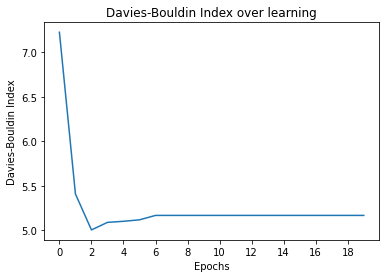

In [63]:
plt.plot(dbis)
plt.xticks(np.arange(0, 20, 2))
plt.title("Davies-Bouldin Index over learning")
plt.xlabel("Epochs")
plt.ylabel("Davies-Bouldin Index")
plt.show

### Good Arbitary Points

[[6.4, 2.8, 5.6, 2.2],
 [5.8, 2.7, 5.1, 1.9],
 [6.9, 3.2, 5.7, 2.3]]

[[4.8, 3.4, 1.6, 0.2],
 [6.0, 2.2, 5.0, 1.5],
 [5.0, 2.0, 3.5, 1.0]]

[[4.8, 3.1, 1.6, 0.2],
 [4.9, 3.1, 1.5, 0.2],
 [6.8, 3.2, 5.9, 2.3]]
 
[[6.4, 3.2, 4.5, 1.5],
 [5.9, 3.0, 4.2, 1.5],
 [4.9, 3.1, 1.5, 0.1]]
 
[[4.9, 3.6, 1.4, 0.1],
 [5.1, 2.5, 3.0, 1.1],
 [6.1, 2.8, 4.0, 1.3]]
 
These points are good to see how the algorithm progresses. Some points might lead to a very unspectacular result.

### Task 2.6.2 Clustered Data vs. Labeled Data
In the beginning, we told our _k_-Means algorithm to separate the data into _k_ clusters after determining _k_ based on the number of cluss labels in the dataset.

Create two plots side-by-side (using subplots), where one side is showing the clustered data and the other side is showing the partitions of the labeled data. 

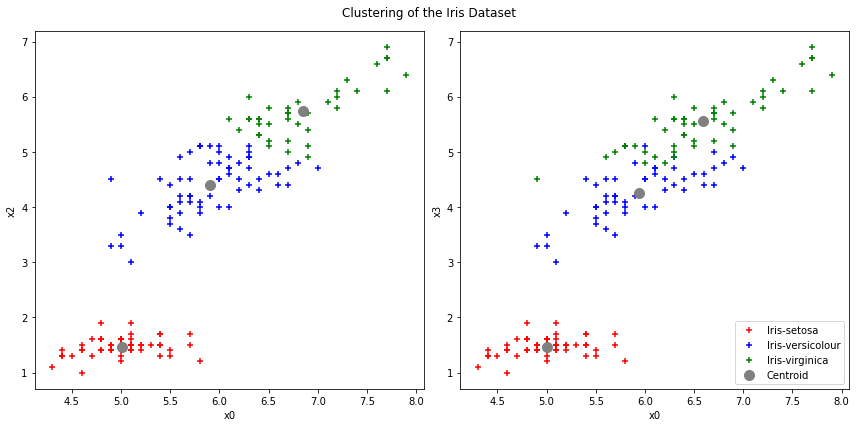

In [64]:
# Clustered Data
split_assignments = split_data_for_vizualization(assignments)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(split_assignments[1][0], split_assignments[1][2], marker='+', c='red', label='Iris-setosa')
plt.scatter(split_assignments[0][0], split_assignments[0][2], marker='+', c='blue', label='Iris-versicolour')
plt.scatter(split_assignments[2][0], split_assignments[2][2], marker='+', c='green', label='Iris-virginica')
plt.scatter([c[0] for c in centres], [c[2] for c in centres], s=100, c='grey', label='Centroid')
plt.xlabel("x" + str(0))
plt.ylabel("x" + str(2))


# Labeled Data
# Reformat the Data so it can be plotted easily 
labeled_data = [[] for i in range(len(np.unique(iris.target)))]
for i in range(len(iris.target)):
    labeled_data[iris.target[i]].append(iris.data[i])

actual_centres = update_centers(iris.data, labeled_data)    

split_data = split_data_for_vizualization(labeled_data)
plt.subplot(1, 2, 2)
plt.scatter(split_data[0][0], split_data[0][2], marker='+', c='red', label='Iris-setosa')
plt.scatter(split_data[1][0], split_data[1][2], marker='+', c='blue', label='Iris-versicolour')
plt.scatter(split_data[2][0], split_data[2][2], marker='+', c='green', label='Iris-virginica')
plt.scatter([c[0] for c in actual_centres], [c[2] for c in actual_centres], s=100, c='grey', label='Centroid')
plt.xlabel("x" + str(0))
plt.ylabel("x" + str(3))

plt.suptitle("Clustering of the Iris Dataset")
plt.legend(loc="lower right")
plt.tight_layout(pad=1.0, w_pad=0.7, h_pad=0.7)
plt.show()

## 2.7 _k_-Means in the Wild
It is quite fun to write the _k_-Means algorithm bottom-up. But, usually, a practitioner would rely on libraries, which have already implemented the algorithm, if possible.
_k_-Means is implemented in the `scikit-learn` library, so we are going to use it to cluster somewhat more complex data and visualize the cluster centers.

In [15]:
from sklearn.datasets import load_digits
from sklearn.cluster import KMeans

### Task 2.7.1 Digits Data and the _k_-Question
Load the [Digits Dataset](https://scikit-learn.org/stable/datasets/toy_dataset.html#digits-dataset) and decide on a reasonable number of cluster centers.

In [24]:
digits = load_digits()
# print(digits.DESCR)
k = 10

### Task 2.7.2 Run the _k_-Means Algorithm
Use the provided _k_-Means object on the digits data and extract the cluster centers.

In [17]:
# Reduce dimensionality of data
reduced_data = PCA(n_components=2).fit_transform(digits.data)

k_means =  KMeans(init="k-means++", n_clusters=k)
k_means.fit(reduced_data)
centroids = k_means.cluster_centers_

### 2.7.3 Plot the Cluster Centers
Plot all the extracted cluster centers as images.

<function matplotlib.pyplot.show(close=None, block=None)>

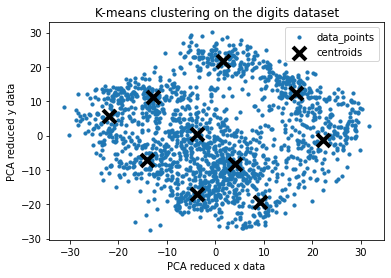

In [19]:
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], s=10, label="data_points")

plt.scatter(
    centroids[:, 0],
    centroids[:, 1],
    marker="x",
    s=169,
    linewidths=4,
    color="black",
    label="centroids"
)
plt.title("K-means clustering on the digits dataset")
plt.legend()
plt.ylabel("PCA reduced y data")
plt.xlabel("PCA reduced x data")
plt.show

Now you have implemented the _k_-Means algorithm bottom-up as well as using the corresponding libraries in a sensible way. Good work!

#### Implement and visualize handwritten kmeans on digits dataset

In [61]:
def plot_manual_digits(assignments, centroids):
    split_assignments = split_data_for_vizualization(assignments)
    colors = ["red", "blue", "green", "grey", "yellow", "m", "c", "#0072BD", "#D95319", "#EDB120"]
    
    clear_output(wait=True)
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    for i in range(len(assignments)):
        plt.scatter(split_assignments[i][0], split_assignments[i][1], marker='+', c=colors[i])
    plt.scatter([c[0] for c in centroids], [c[1] for c in centroids], marker='x', s=200, linewidths=4, c='black', label='Centroid')
    plt.xlabel("x" + str(0))
    plt.ylabel("x" + str(2))

    plt.subplot(1, 2, 2)
    for i in range(len(assignments)):
        plt.scatter(split_assignments[i][0], split_assignments[i][1], marker='+', c=colors[i])
    plt.scatter([c[0] for c in centroids], [c[1] for c in centroids], marker='x', s=200, linewidths=4, c='black', label='Centroid')
    plt.xlabel("x" + str(0))
    plt.ylabel("x" + str(3))

    plt.suptitle("Clustering of the Digits Dataset")
    plt.legend(loc="lower right")
    plt.tight_layout(pad=1.0, w_pad=0.7, h_pad=0.7)
    plt.show()

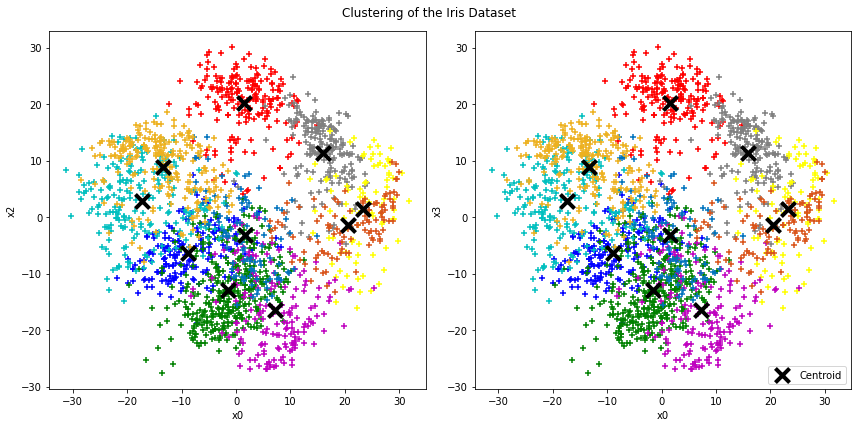

In [60]:
iterations = 30
initial_data = PCA(n_components=4).fit_transform(digits.data)
centres = get_arbitary_points(iris, k)
dbis = []

for i in range(iterations):
    assignments = compute_assignments(initial_data, centres)
    new_centres = update_centers(initial_data, assignments)
    dbi = db_index(initial_data, new_centres, assignments)
    plot_manual_digits(assignments, centres)
    centres = new_centres
    dbis.append(dbi)

    